# Sub-Task 4 (Cart-Pole Problem):

In [1]:
#Imports of the necessary libraries
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import time
import math
import random 
from typing import Tuple

In [2]:
"""
This code is adapted from the cart-pole problem tutorial at:

https://kvfrans.com/simple-algoritms-for-solving-cartpole/

Code availabe at:

https://github.com/kvfrans/openai-cartpole

Added a graph to visualize reward/penalty data, adjusted for python 7

All credit goes to the authors.

"""

'\nThis code is adapted from the cart-pole problem tutorial at:\n\nhttps://kvfrans.com/simple-algoritms-for-solving-cartpole/\n\nCode availabe at:\n\nhttps://github.com/kvfrans/openai-cartpole\n\nAdded a graph to visualize reward/penalty data, adjusted for python 7\n\nAll credit goes to the authors.\n\n'

### Random

#### Visualise the Environment without any training

In [3]:
#Lambda obs 1 the cart moves right
#lambda obs 0 the cart moves left
env = gym.make('CartPole-v1')
policy = lambda obs: 1

for _ in range(5):
    obs = env.reset()
    for _ in range(80):
        actions = policy(obs)
        obs, reward, done, info = env.step(actions) 
        env.render()
        time.sleep(0.05)

env.close()

C:\Users\jarac\anaconda3\envs\hello-tf\lib\site-packages\gym\envs\classic_control\cartpole.py:164: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


In [4]:
#Represents the properties of the Cart-pole at any given time
#Made up of Cart Position, Cart Velocity, Pole Angle, and Pole Velocity at the tip
obs

array([11.49203  , 14.52698  , -5.2476687,  1.039866 ], dtype=float32)

In [5]:
#Reward is 1 when the angle of the pole is <12 degrees
#Reward is 0 otherwise
reward

0.0

In [6]:
#For every timestep the pole is straight +1 reward
#Helps determine how optimal the random set of weights is
#Episode is run, then final output is the cumulative reward
def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

In [7]:
#Random agent "training" proccess 
def train(submit):
    env = gym.make('CartPole-v1')
    if submit:
        env.monitor.start('cartpole-experiments/', force=True)
    counter = 0
    bestparams = None
    bestreward = 0
    for _ in range(10000):
        counter += 1
        parameters = np.random.rand(4) * 2 - 1
        reward = run_episode(env,parameters)
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            if reward == 200:
                break

    if submit:
        for _ in range(100):
            run_episode(env,bestparams)
        env.monitor.close()

    return counter

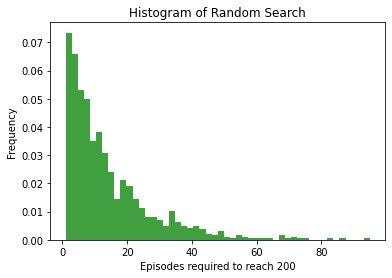

13.879


In [8]:
#Creates histogram of random agent
results = []
for _ in range(1000):
    results.append(train(submit=False))

plt.hist(results,50,density=1, facecolor='g', alpha=0.75, stacked = True)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

print (np.sum(results) / 1000.0)

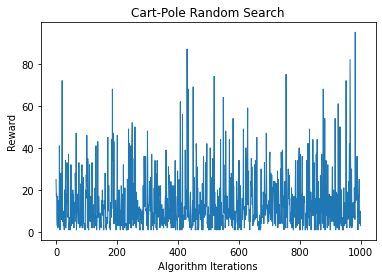

In [9]:
#Creates a Graph of Reward Data
plt.title("Cart-Pole Random Search")
plt.plot(results, linewidth=1)
plt.ylabel('Reward')
plt.xlabel('Algorithm Iterations')
plt.show()

### Q-Learning

In [10]:
"""
This code is adapted from the cart-pole problem Q-learning demo at:

https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1

Added a graph to visualize reward data, adjusted for python 7

All credit goes to the authors.

"""

'\nThis code is adapted from the cart-pole problem Q-learning demo at:\n\nhttps://github.com/RJBrooker/Q-learning-demo-Cartpole-V1\n\nAdded a graph to visualize reward data, adjusted for python 7\n\nAll credit goes to the authors.\n\n'

In [11]:
#Creates the Cart-pole environment VIA Gym
env = gym.make('CartPole-v1').env

In [12]:
#Simple policy function to maximise total reward
#Moves the cart in the same direction as the pole
policy = lambda _,__,___, tip_velocity : int( tip_velocity > 0 )

In [13]:
#Converts Cart-poles continuous state space into a discrete one
#This is done by dividing the state space into discrete buckets
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [14]:
#Initialise the Q value table with zeros
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

In [15]:
#Creates a policy function, uses the Q-table and greedily selecting the highest Q value
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])

In [16]:
#Update Function
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [17]:
#Decaying Learning Rate so learning happens more quickly at the start than end
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [18]:
#Decaying Exploration Rate
#Proportion of random actions to insert, state space is explored in this manner
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [20]:
#Training
#Hit stop after visualization demo as q-learning agent succeeds in keeping the pole upright
#Will not stop without manual intervention 
n_episodes = 10000
episode_reward = 0
sporadic = 0
results = []
for e in range(n_episodes):
    
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment/timestep 
        obs, reward, done, _ = env.step(action)
        #Add the rewards together over each iteration
        episode_reward += reward
        new_state = discretizer(*obs)
        results.append(episode_reward)
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        
        current_state = new_state
        
        #Render the cartpole environment
        env.render()

KeyboardInterrupt: 

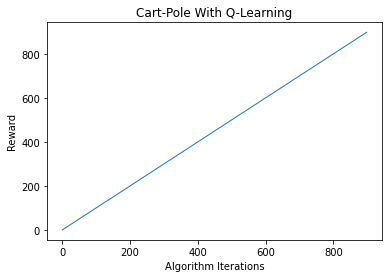

In [21]:
#Creates a Graph of cumulative reward data
plt.title("Cart-Pole With Q-Learning")
plt.plot(results, linewidth=1)
plt.ylabel('Reward')
plt.xlabel('Algorithm Iterations')
plt.show()

### Policy-Gradient

In [22]:
#Gives the probabilty of taking respective actions, given a set of observations 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out

#Uses tensforflow to compute gradient
def policy_gradient():
    with tf.variable_scope("policy"):
        params = tf.get_variable("policy_parameters",[4,2])
        state = tf.placeholder("float",[None,4])
        actions = tf.placeholder("float",[None,2])
        advantages = tf.placeholder("float",[None,1])
        linear = tf.matmul(state,params)
        probabilities = tf.nn.softmax(linear)
        good_probabilities = tf.reduce_sum(tf.mul(probabilities, actions),reduction_indices=[1])
        eligibility = tf.log(good_probabilities) * advantages
        loss = -tf.reduce_sum(eligibility)
        optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        return probabilities, state, actions, advantages, optimizer

In [23]:
#Defines some value for each state, that contains the average return starting from that state
#Uses a 1 hidden layer neural network
def value_gradient():
    with tf.variable_scope("value"):
        state = tf.placeholder("float",[None,4])
        newvals = tf.placeholder("float",[None,1])
        w1 = tf.get_variable("w1",[4,10])
        b1 = tf.get_variable("b1",[10])
        h1 = tf.nn.relu(tf.matmul(state,w1) + b1)
        w2 = tf.get_variable("w2",[10,1])
        b2 = tf.get_variable("b2",[1])
        calculated = tf.matmul(h1,w2) + b2
        diffs = calculated - newvals
        loss = tf.nn.l2_loss(diffs)
        optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
        return calculated, state, newvals, optimizer, loss

In [24]:
#Runs an episode/iteration 
def run_episode(env, policy_grad, value_grad, sess):
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer = policy_grad
    vl_calculated, vl_state, vl_newvals, vl_optimizer, vl_loss = value_grad
    observation = env.reset()
    totalreward = 0
    states = []
    actions = []
    advantages = []
    transitions = []
    update_vals = []
    
    for _ in range(200):
        # calculate policy
        obs_vector = np.expand_dims(observation, axis=0)
        probs = sess.run(pl_calculated,feed_dict={pl_state: obs_vector})
        action = 0 if random.uniform(0,1) < probs[0][0] else 1
        # record the transition
        states.append(observation)
        actionblank = np.zeros(2)
        actionblank[action] = 1
        actions.append(actionblank)
        # take the action in the environment
        old_observation = observation
        observation, reward, done, info = env.step(action)
        transitions.append((old_observation, action, reward))
        totalreward += reward

        if done:
            break
    for index, trans in enumerate(transitions):
        obs, action, reward = trans

        # calculate discounted monte-carlo return
        future_reward = 0
        future_transitions = len(transitions) - index
        decrease = 1
        for index2 in range(future_transitions):
            future_reward += transitions[(index2) + index][2] * decrease
            decrease = decrease * 0.97
        obs_vector = np.expand_dims(obs, axis=0)
        currentval = sess.run(vl_calculated,feed_dict={vl_state: obs_vector})[0][0]

        # advantage: how much better was this action than normal
        advantages.append(future_reward - currentval)

        # update the value function towards new return
        update_vals.append(future_reward)

    # update value function
    update_vals_vector = np.expand_dims(update_vals, axis=1)
    sess.run(vl_optimizer, feed_dict={vl_state: states, vl_newvals: update_vals_vector})
    # real_vl_loss = sess.run(vl_loss, feed_dict={vl_state: states, vl_newvals: update_vals_vector})

    advantages_vector = np.expand_dims(advantages, axis=1)
    sess.run(pl_optimizer, feed_dict={pl_state: states, pl_advantages: advantages_vector, pl_actions: actions})

    return totalreward

In [25]:
"""
****NOTE FOR MARKER*****
Somaiyeh has reviewed and discussed this code with me and asked me to make a note for you
If you are unable to run the final block it is due to the gym version not an error in the code 
She asked that I not be penalised according to this
Thank you

"""
#Running code to create the environment and run the policy gradient agent
env = gym.make('CartPole-v1')
id='CartPole-v1'
entry_point='gym.envs.classic_control:CartPoleEnv'
max_episode_steps=500
reward_threshold=475.0
env.monitor.start('cartpole-hill/', force=True)
policy_grad = policy_gradient()
value_grad = value_gradient()
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
for i in range(2000):
    reward = run_episode(env, policy_grad, value_grad, sess)
    if reward == 200:
        print ("reward 200")
        print (i)
        break
t = 0
for _ in range(1000):
    reward = run_episode(env, policy_grad, value_grad, sess)
    t += reward
print (t / 1000)
env.monitor.close()

AttributeError: 'CartPoleEnv' object has no attribute 'monitor'